In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, lars_path
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn import linear_model
from sklearn.preprocessing import scale, Imputer
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# read data
df = pd.read_csv("dummt_transformed.csv")
df = df.iloc[:,1:]

In [3]:
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [4]:
# check missing values
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data.Total > 0]

,Total,Percent
LotFrontage,259,0.177397


In [5]:
variables = df.columns.tolist()
y_index = df.columns.tolist().index('SalePrice')
#NA_index = df.columns.tolist().index('LotFrontage')
y = np.log(df.iloc[:,y_index])
variables.pop(y_index)
#variables.pop(NA_index)
X = df.loc[:,variables]

imp = Imputer(missing_values = 'NaN', strategy = "mean", axis = 0)
imp = imp.fit(X)
X = imp.transform(X)

In [6]:
X_df = df.loc[:,variables]

### Linear Regression

In [ ]:
model = LinearRegression()
score = np.mean(np.sqrt(-cross_val_score(model, X, y,scoring="neg_mean_squared_error", cv = y.shape[0])))
print "linear regression score: ", score

### Ridge Regression

In [68]:
alphas = np.logspace(-6,4,11)
alphas

array([  1.00000000e-06,   1.00000000e-05,   1.00000000e-04,
         1.00000000e-03,   1.00000000e-02,   1.00000000e-01,
         1.00000000e+00,   1.00000000e+01,   1.00000000e+02,
         1.00000000e+03,   1.00000000e+04])

In [69]:
rcv = RidgeCV(alphas = alphas, store_cv_values=True,normalize=False)
rcv.fit(X,y)
cv_vals = rcv.cv_values_
LOOr = cv_vals.mean(axis=0)

In [70]:
zip(alphas,LOOr)

[(9.9999999999999995e-07, 0.039693601249437112),
 (1.0000000000000001e-05, 0.039688037106184987),
 (0.0001, 0.039630429011628006),
 (0.001, 0.038952131058391889),
 (0.01, 0.033813169666875989),
 (0.10000000000000001, 0.025595562272544076),
 (1.0, 0.022247875076717358),
 (10.0, 0.021038992601428608),
 (100.0, 0.022146950099809964),
 (1000.0, 0.026786949177101713),
 (10000.0, 0.034330194462211569)]

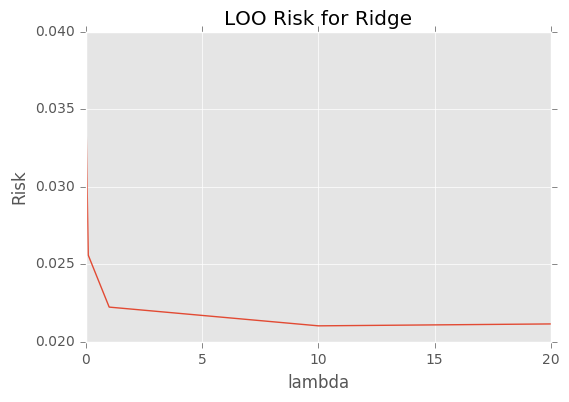

In [72]:
plt.plot(alphas,LOOr)
plt.xlabel('lambda')
plt.ylabel('Risk')
plt.title('LOO Risk for Ridge')
plt.xlim([0,20])
#plt.ylim([0.006,0.010])
plt.show()

In [73]:
min(dict(zip(alphas,LOOr)).items(), key=lambda x: x[1])

(10.0, 0.021038992601428608)

In [74]:
print "LOO square error risk for ridge under the best lambda is {:.7f}".format(
    min(dict(zip(alphas,LOOr)).items(), key=lambda x: x[1])[1])

LOO square error risk for ridge under the best lambda is 0.0210390


### Lasso Path and Lars Path

In [14]:
lasso_path = lars_path(np.array(X),np.array(y),method="lasso")
#lars_path = lars_path(np.array(X),np.array(y),method="lar")

/Users/alice/anaconda/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 253 iterations, i.e. alpha=8.869e-05, with an active set of 195 regressors, and the smallest cholesky pivot element being 8.429e-08
  ConvergenceWarning)
/Users/alice/anaconda/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 296 iterations, alpha=1.454e+01, previous alpha=4.434e-05, with an active set of 223 regressors.
  ConvergenceWarning)


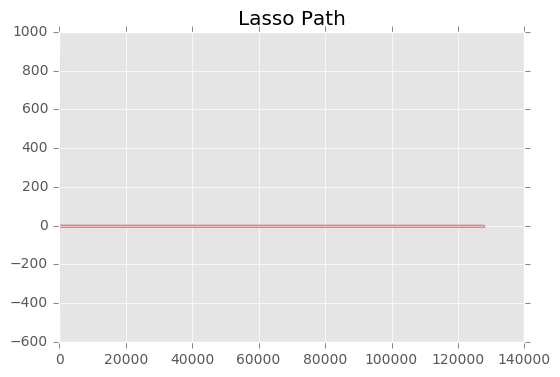

In [19]:
for j in xrange(X.shape[1]):
    _ = plt.plot(lasso_path[0],lasso_path[2][j,:])
#_ = plt.xlim([0,6])
#_ = plt.xlim(plt.xlim()[::-1])
#_ = ax[0].set_ylim([-500,500])
_ = plt.title("Lasso Path")

### Lasso

In [20]:
loo = LeaveOneOut()
looiter = loo.split(X)
lasso_model = LassoCV(cv=looiter)
lasso_model.fit(X,y)
print("The selected lambda value is {:.2f}".format(lasso_model.alpha_))

The selected lambda value is 1.03


In [21]:
np.mean(lasso_model.mse_path_[lasso_model.alphas_ == lasso_model.alpha_])

0.039885723197330143

### Fitting Ridge Regression using the variables selected by Lasso

In [66]:
variable_chosen = X_df.iloc[:,lasso_model.coef_ != 0]
variable_chosen.columns

Index([u'LotArea', u'YearBuilt', u'YearRemodAdd', u'MasVnrArea', u'BsmtFinSF1',
       u'TotalBsmtSF', u'2ndFlrSF', u'GrLivArea', u'GarageYrBlt',
       u'GarageArea', u'WoodDeckSF', u'ScreenPorch', u'MiscVal'],
      dtype='object')

In [42]:
alphas = np.logspace(-6,4,11)
rcv = RidgeCV(alphas = alphas, store_cv_values=True,normalize=False)
rcv.fit(variable_chosen,y)
cv_vals = rcv.cv_values_
LOOr = cv_vals.mean(axis=0)

In [46]:
dict(zip(alphas,LOOr))

{9.9999999999999995e-07: 0.036139863571387598,
 1.0000000000000001e-05: 0.036139863571392421,
 0.0001: 0.036139863571441548,
 0.001: 0.036139863571932544,
 0.01: 0.036139863576842124,
 0.10000000000000001: 0.0361398636259379,
 1.0: 0.036139864116914021,
 10.0: 0.036139869028501859,
 100.0: 0.03613991832697494,
 1000.0: 0.036140429504468316,
 10000.0: 0.036147296266618362}

In [43]:
min(dict(zip(alphas,LOOr)).items(), key=lambda x: x[1])

(9.9999999999999995e-07, 0.036139863571387598)

In [44]:
# The mse here is smaller than Lasso

### Decision Tree Regressor

In [47]:
from sklearn.tree import DecisionTreeRegressor

In [48]:
loo = LeaveOneOut()
regressor = DecisionTreeRegressor(random_state=0, max_features = 20)
cross_val_score(regressor, X, y, cv=loo,scoring='neg_mean_squared_error')

array([-0.00963151, -0.03633612, -0.01537056, ..., -0.00749402,
       -0.00113742, -0.00090314])

In [49]:
np.mean(-cross_val_score(regressor, X, y, cv=loo,scoring='neg_mean_squared_error'))

0.063554902546635969

In [54]:
#regressor.fit(X,y)

In [53]:
#X_df.columns[regressor.feature_importances_ != 0]

In [57]:
feature_importance = dict(zip(X_df.columns,regressor.feature_importances_))

In [62]:
import operator
rank_importance = pd.DataFrame(sorted(feature_importance.iteritems(), key=operator.itemgetter(1), reverse=True)[:20])

In [108]:
rank_importance= rank_importance.rename(columns = {0:"Variables",1:"Feature Importance"})

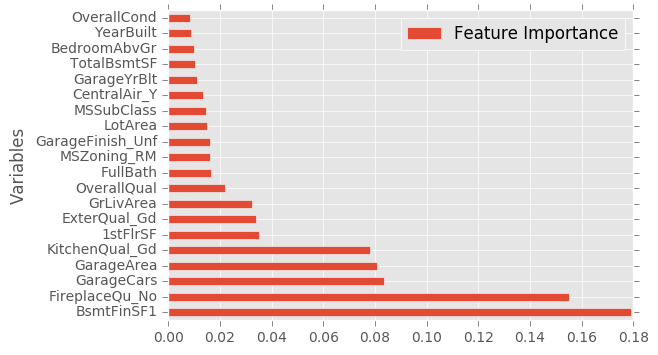

In [109]:
rank_importance.plot.barh(x = "Variables")

In [77]:
rank_importance.sort_values(by = 1,ascending = False).head(10).loc[:,0].tolist()

['BsmtFinSF1',
 'FireplaceQu_No',
 'GarageCars',
 'GarageArea',
 'KitchenQual_Gd',
 '1stFlrSF',
 'ExterQual_Gd',
 'GrLivArea',
 'OverallQual',
 'FullBath']

In [99]:
variable_select_DT = rank_importance.sort_values(by = 1,ascending = False).head(20).loc[:,0].tolist()
X_DT = pd.DataFrame(X_df.loc[:,variable_select_DT])
X_DT.head()

,BsmtFinSF1,FireplaceQu_No,GarageCars,GarageArea,KitchenQual_Gd,1stFlrSF,ExterQual_Gd,GrLivArea,OverallQual,FullBath,MSZoning_RM,GarageFinish_Unf,LotArea,MSSubClass,CentralAir_Y,GarageYrBlt,TotalBsmtSF,BedroomAbvGr,YearBuilt,OverallCond
0,706,1.0,2,548,1.0,856,1.0,1710,7,2,0.0,0.0,8450,60,1.0,2003.0,856,3,2003,5
1,978,0.0,2,460,0.0,1262,0.0,1262,6,2,0.0,0.0,9600,20,1.0,1976.0,1262,3,1976,8
2,486,0.0,2,608,1.0,920,1.0,1786,7,2,0.0,0.0,11250,60,1.0,2001.0,920,3,2001,5
3,216,0.0,3,642,1.0,961,0.0,1717,7,1,0.0,1.0,9550,70,1.0,1998.0,756,3,1915,5
4,655,0.0,3,836,1.0,1145,1.0,2198,8,2,0.0,0.0,14260,60,1.0,2000.0,1145,4,2000,5


In [100]:
alphas = np.logspace(-6,4,11)
rcv = RidgeCV(alphas = alphas, store_cv_values=True,normalize=False)
rcv.fit(X_DT,y)
cv_vals = rcv.cv_values_
LOOr = cv_vals.mean(axis=0)
zip(alphas,LOOr)

[(9.9999999999999995e-07, 0.024605468843069984),
 (1.0000000000000001e-05, 0.024605468826575265),
 (0.0001, 0.024605468661630291),
 (0.001, 0.024605467012322739),
 (0.01, 0.024605450533552658),
 (0.10000000000000001, 0.024605287173313263),
 (1.0, 0.024603793380193487),
 (10.0, 0.024600385489892761),
 (100.0, 0.024909719091739894),
 (1000.0, 0.028215339822279344),
 (10000.0, 0.036816055079781744)]

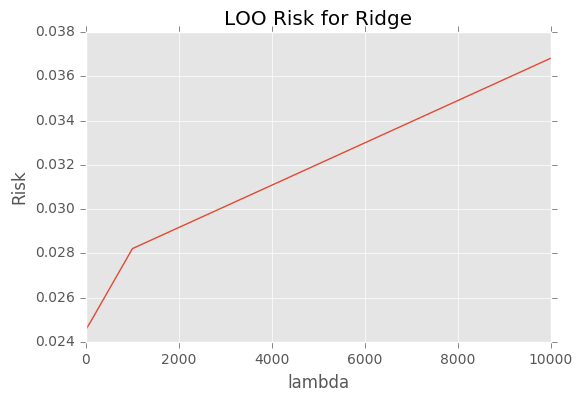

In [101]:
plt.plot(alphas,LOOr)
plt.xlabel('lambda')
plt.ylabel('Risk')
plt.title('LOO Risk for Ridge')
#plt.xlim([0,20])
#plt.ylim([0.006,0.010])
plt.show()

In [102]:
min(dict(zip(alphas,LOOr)).items(), key=lambda x: x[1])

(10.0, 0.024600385489892761)

### Adding XGBOOST

Still not figure how to do this @@

In [26]:
import xgboost as xgb